In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
import urllib    

tar_data_list=['train.tar.gz','test.tar.gz','extra.tar.gz']
for sample_data in tar_data_list:
    print ("Size of "+sample_data +" : ",urllib.urlopen(url+sample_data).info()['Content-Length'])   

Size of train.tar.gz :  404141560
Size of test.tar.gz :  276555967
Size of extra.tar.gz :  1955489752


In [3]:
def maybe_download(filename, expected_bytes):
#   """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo_size = os.stat(filename).st_size
  if statinfo_size == expected_bytes:
    print ('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename
    
train_filename = maybe_download('train.tar.gz',404141560)  #TODO
test_filename = maybe_download('test.tar.gz',276555967)  #TODO
extra_filename = maybe_download('extra.tar.gz',1955489752)

Found and verified train.tar.gz
Found and verified test.tar.gz
Found and verified extra.tar.gz


In [4]:
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = root
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
extra_folders = maybe_extract(extra_filename)

train already present - Skipping extraction of train.tar.gz.
train
test already present - Skipping extraction of test.tar.gz.
test
extra already present - Skipping extraction of extra.tar.gz.
extra


In [5]:
#!pip install h5py

In [6]:
#Reference from udacity Forum: https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [7]:
train_folders = 'train'
test_folders = 'test'
extra_folders = 'extra'
#train_data creation from digitSturct.mat
fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

print (type(train_data))   #type is list

<type 'list'>


In [8]:
#test for  the purpose  of the analysis of dataset.
print("boxes, filename:",len(train_data[0]))
print("boxes, filename:",len(train_data[1]))
#print out  train_data from element0 to element1(2 dataset)
train_data[0:2]

boxes, filename: 2
boxes, filename: 2


[{'boxes': [{'height': 219.0,
    'label': 1.0,
    'left': 246.0,
    'top': 77.0,
    'width': 81.0},
   {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}],
  'filename': '1.png'},
 {'boxes': [{'height': 32.0,
    'label': 2.0,
    'left': 77.0,
    'top': 29.0,
    'width': 23.0},
   {'height': 32.0, 'label': 3.0, 'left': 98.0, 'top': 25.0, 'width': 26.0}],
  'filename': '2.png'}]

In [9]:
#test
print(len(train_data))
print(train_data[0])
print("*"*50)
print("train_data[0]['boxes']:\n",train_data[0]['boxes'])
print("*"*20,"same following two (dictionary) **************")
print("train_data[0]['boxes'][0]:\n",train_data[0]['boxes'][0])
print("train_data[0]['boxes'][1]:\n",train_data[0]['boxes'][1])
print("train_data[0]['boxes'][1]['width']:\n",train_data[0]['boxes'][1]['width'])
print("*"*30)
for e in train_data[0]['boxes'][1].keys():
    print (e)
for e in train_data[0]['boxes'][1].values():
    print (e)
#print(train_data[0][[1,2,3,4]])
#print(extra_data[0][[1,2,3,4]])

33402
{'boxes': [{'width': 81.0, 'top': 77.0, 'label': 1.0, 'left': 246.0, 'height': 219.0}, {'width': 96.0, 'top': 81.0, 'label': 9.0, 'left': 323.0, 'height': 219.0}], 'filename': '1.png'}
**************************************************
train_data[0]['boxes']:
 [{'width': 81.0, 'top': 77.0, 'label': 1.0, 'left': 246.0, 'height': 219.0}, {'width': 96.0, 'top': 81.0, 'label': 9.0, 'left': 323.0, 'height': 219.0}]
******************** same following two (dictionary) **************
train_data[0]['boxes'][0]:
 {'width': 81.0, 'top': 77.0, 'label': 1.0, 'left': 246.0, 'height': 219.0}
train_data[0]['boxes'][1]:
 {'width': 96.0, 'top': 81.0, 'label': 9.0, 'left': 323.0, 'height': 219.0}
train_data[0]['boxes'][1]['width']:
 96.0
******************************
width
top
label
left
height
96.0
81.0
9.0
323.0
219.0


In [10]:
#test

my_list=[]
for i in xrange(6):
    my_list.append(train_data[i]['boxes'][1]['label'])
print(my_list)   
print("*"*50)
for i in xrange(6):
    print(train_data[i]['boxes'][0]['label'])


[9.0, 3.0, 5.0, 3.0, 1.0, 3.0]
**************************************************
1.0
2.0
2.0
9.0
3.0
3.0


In [11]:
#test 
my_list1=[]
for i in xrange(2):
#     for j in xrange(5):
        my_list1.append(train_data[0]['boxes'][i]['label'])
print(my_list1)        
print("train_data[0]['filename']:",train_data[0]['filename'])

[1.0, 9.0]
train_data[0]['filename']: 1.png


In [12]:
#test 1stt element of train_data structure 
train_data[0] #print(len(train_data[0])) : output is 2

{'boxes': [{'height': 219.0,
   'label': 1.0,
   'left': 246.0,
   'top': 77.0,
   'width': 81.0},
  {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}],
 'filename': '1.png'}

In [13]:
#test_data creation from digitSturct.mat
fin = os.path.join(test_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()

In [14]:
#test for test_data,  first element's contents
test_data[0]

{'boxes': [{'height': 30.0,
   'label': 5.0,
   'left': 43.0,
   'top': 7.0,
   'width': 19.0}],
 'filename': '1.png'}

In [17]:
#extra_data creation from digitSturct.mat
fin = os.path.join(extra_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
extra_data = dsf.getAllDigitStructure_ByDigit()


In [18]:
#!pip install image

In [19]:
from PIL import Image
train_imsize = np.ndarray([len(train_data),2])  #random num:(33402,2)
for i in np.arange(len(train_data)): #33402
    filename = train_data[i]['filename']  #train_data[0]['filename']:1.png
    fullname = os.path.join(train_folders, filename)
    im = Image.open(fullname)
    train_imsize[i, :] = im.size[:] 


In [20]:
print("max num along column 0:",np.amax(train_imsize[:,0]), 
      ", max num along column 1:",np.amax(train_imsize[:,1]))
print("min num along column 0:",np.amin(train_imsize[:,0]),
       ", min num along column 1:",np.amin(train_imsize[:,1]))

max num along column 0: 876.0 , max num along column 1: 501.0
min num along column 0: 25.0 , min num along column 1: 12.0


In [21]:
#test
from PIL import Image
print("train_imsize = np.ndarray([len(train_data),2])::(33402,2):\n",
      np.ndarray([len(train_data),2])) #(33402,2)
i=0
f1=train_data[i]['filename']
print("train_data[i]['filename']:",f1)
full1=os.path.join(train_folders, f1)
print("full1 name of image file:",full1)
im=Image.open(fullname)
print(im)
train_imsize[i, :] = im.size[:] #random num:(33402,2) from above  cell
print("train_imsize[0, :]:",train_imsize[i, :])
print("len(train_imsize[:,0]):",len(train_imsize[:, 0]))
print("train_imsize[:3,0]:",train_imsize[:3, 0])
print("len(train_imsize[:,1]):",len(train_imsize[:, 1]))
print("train_imsize[:3,1]:",train_imsize[:3, 1])

train_imsize = np.ndarray([len(train_data),2])::(33402,2):
 [[  6.93955345e-310   6.93955345e-310]
 [  2.39935479e-315   2.39935479e-315]
 [  1.09341629e-316   1.09341510e-316]
 ..., 
 [  3.38526666e-316   3.38526547e-316]
 [  3.38526429e-316   3.38526310e-316]
 [  3.38526192e-316   3.38526073e-316]]
train_data[i]['filename']: 1.png
full1 name of image file: train/1.png
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=113x41 at 0x7FBE8D7B2ED0>
train_imsize[0, :]: [ 113.   41.]
len(train_imsize[:,0]): 33402
train_imsize[:3,0]: [ 113.  199.   52.]
len(train_imsize[:,1]): 33402
train_imsize[:3,1]: [ 41.  83.  23.]


In [22]:
test_imsize = np.ndarray([len(test_data),2]) #random num:(33402,2)
for i in np.arange(len(test_data)): #33402
    filename = test_data[i]['filename'] #train_data[0]['filename']:1.png
    fullname = os.path.join(test_folders, filename)
    im = Image.open(fullname)
    test_imsize[i, :] = im.size[:]
#maximum number among all elements in column 0 and maximum number in column 1
print("max num along column 0:",np.amax(test_imsize[:,0]), 
      ", max num along column 1:",np.amax(test_imsize[:,1]))
#minimum number among all elements in column 0 and minimum number in column 1
print("min num along column 0:",np.amin(test_imsize[:,0]), 
      ", min num along column 1:",np.amin(test_imsize[:,1]))

max num along column 0: 1083.0 , max num along column 1: 516.0
min num along column 0: 31.0 , min num along column 1: 13.0


In [23]:
extra_imsize = np.ndarray([len(extra_data),2])
for i in np.arange(len(extra_data)):
    filename = extra_data[i]['filename']
    fullname = os.path.join(extra_folders, filename)
    im = Image.open(fullname)
    extra_imsize[i, :] = im.size[:]
#maximum number among all elements in column 0 and maximum number in column 1
print("max num along column 0:",np.amax(extra_imsize[:,0]), 
      ", max num along column 1:",np.amax(extra_imsize[:,1]))
#minimum number among all elements in column 0 and minimum number in column 1
print("min num along column 0:",np.amin(extra_imsize[:,0]), 
      ", min num along column 1:",np.amin(extra_imsize[:,1]))

max num along column 0: 668.0 , max num along column 1: 415.0
min num along column 0: 22.0 , min num along column 1: 13.0


In [24]:
#test
print(np.where(train_imsize[:,0]==876))
print(np.where(train_imsize[:,0]==25))
print(np.where(test_imsize[:,0]==1083))
print(np.where(test_imsize[:,0]==31))
print(np.where(extra_imsize[:,0]==668))
print(np.where(extra_imsize[:,0]==22))

(array([  410,  4163, 15855, 30484]),)
(array([9747]),)
(array([ 1722,  2949,  6233, 12862]),)
(array([  459,  5352,  7776, 11257, 12191]),)
(array([ 32352,  78946, 104221, 191787, 198954]),)
(array([ 19731,  25534,  56510, 110583, 127903, 165055, 183311, 184799,
       193713, 195221]),)


In [25]:
#test for train_data contnets
print("len(train_data[0]['boxes']):",len(train_data[0]['boxes']))
print("train_data[0]:\n",train_data[0])
print("len(train_data[4440]['boxes']):",len(train_data[4440]['boxes']))
print("train_data[4440]:\n",train_data[4440])
for i in xrange(3):
    print(len(train_data[i]['boxes'])) # now 2 but  it can be 1,2,3,4
print(np.ndarray([len(train_data[i]['boxes'])], dtype='float32'))#np.ndarray([2],dtype=f)

len(train_data[0]['boxes']): 2
train_data[0]:
 {'boxes': [{'width': 81.0, 'top': 77.0, 'label': 1.0, 'left': 246.0, 'height': 219.0}, {'width': 96.0, 'top': 81.0, 'label': 9.0, 'left': 323.0, 'height': 219.0}], 'filename': '1.png'}
len(train_data[4440]['boxes']): 3
train_data[4440]:
 {'boxes': [{'width': 14.0, 'top': 20.0, 'label': 1.0, 'left': 65.0, 'height': 35.0}, {'width': 20.0, 'top': 19.0, 'label': 2.0, 'left': 80.0, 'height': 35.0}, {'width': 19.0, 'top': 20.0, 'label': 4.0, 'left': 100.0, 'height': 35.0}], 'filename': '4441.png'}
2
2
2
[ -1.10116082e+32   4.58252624e-41]


#### Following graph shows almost of number of digit charcters are spread from 1  to  5 number characters. It is optimal to train 1,2,3,4,5 number of  characters.


Number of character:corresponding frequncy -  Counter({2: 18130, 3: 8691, 1: 5137, 4: 1434, 5: 9, 6: 1})


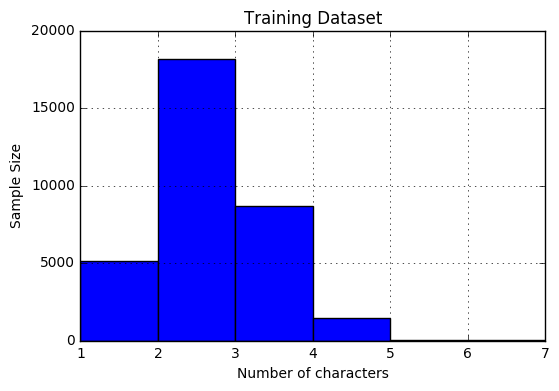

In [26]:
from collections import Counter
digit_length_list=[]
for  i in xrange(len(train_data)): #33402
    digit_length_list.append(len(train_data[i]['boxes']))  
digit_count=Counter(digit_length_list)  
print("Number of character:corresponding frequncy - ",digit_count) 
l = plt.bar(digit_count.keys(), digit_count.values(), 1, color="blue")

plt.xlabel('Number of characters')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Training Dataset')

plt.show()


Number of character:corresponding frequncy -  Counter({2: 8356, 1: 2483, 3: 2081, 4: 146, 5: 2})


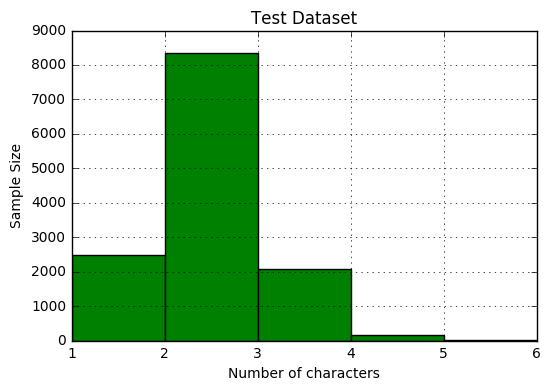

In [27]:
from collections import Counter
digit_length_list=[]
for  i in xrange(len(test_data)): #33402
    digit_length_list.append(len(test_data[i]['boxes']))   
digit_count=Counter(digit_length_list)  
print("Number of character:corresponding frequncy - ",digit_count) 
l = plt.bar(digit_count.keys(), digit_count.values(), 1, color="green")

plt.xlabel('Number of characters')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Test Dataset')

plt.show()

Number of character:corresponding frequncy -  Counter({3: 106789, 2: 71726, 4: 14338, 1: 9385, 5: 115})


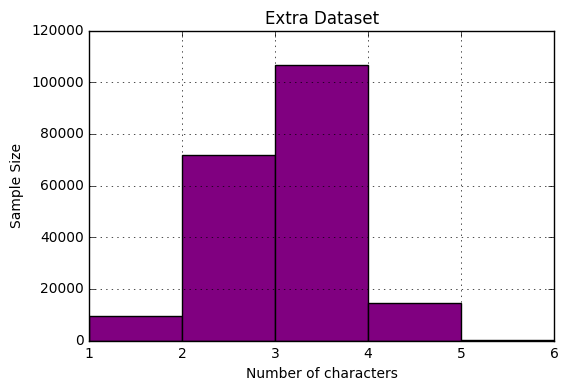

In [28]:
from collections import Counter
digit_length_list=[]
for  i in xrange(len(extra_data)): #33402
    digit_length_list.append(len(extra_data[i]['boxes']))   
digit_count=Counter(digit_length_list) 
print("Number of character:corresponding frequncy - ",digit_count) 
l = plt.bar(digit_count.keys(), digit_count.values(), 1, color="purple")

plt.xlabel('Number of characters')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Extra Dataset')

plt.show()

In [29]:
import PIL.Image as Image
#generate dataset to fit for training and specific weights are applied to convet  to grayscale. 
def generate_dataset(data, folder):
    
    #len(train_data):33402,len(test_data):13068,len(extra):202353
    dataset = np.ndarray([len(data),32,32,1], dtype='float32') #train (33402,32.32,1)
    labels = np.ones([len(data),6], dtype=int) * 10 #train: (33402,6)
    #for  loop : i element, j boxes in i element.
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        num_digit = len(boxes)  #i=0, len(boxes) =2, it  can be 1,2,3,4
        #initialize with number of boxes or digit  number.
        labels[i,0] = num_digit #now:labels[0,0]=2,next loop: labels[1,0]=2, labels[2,0]=2
        top = np.ndarray([num_digit], dtype='float32') #ndarray([2], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):  #i=0, len(boxes) =2, it  can be 1,2,3,4
            if j < 5:  
    #From above train_data of test cell. Value of each train_data is as follow.         
    #i=0,j=0:labels[0,1]=boxes[0]['label']=data[0]['boxes'][0]['label']=1.0
    #i=0,j=1:labels[0,2]=boxes[1]['label']=data[0]['boxes'][1]['label']=9.0
    #i=4440,j=0:labels[4440,1]=boxes[0]['label']=data[4440]['boxes'][0]['label']=1.0
    #i=4440,j=1:labels[4440,2]=boxes[1]['label']=data[4440]['boxes'][1]['label']=2.0
    #i=4440,j=2:labels[4440,3]=boxes[2]['label']=data[4440]['boxes'][2]['label']=4.0
                labels[i,j+1] = boxes[j]['label'] 
                if boxes[j]['label'] == 10: labels[i,j+1] = 0  
            else: print('#',i,'image has more than 5 digits.')
    #i=0,j=0: top[0] = boxes[0]['top'] =77.0
    #i=0,j=1: top[0] = boxes[1]['top'] =81.0           
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        im_top = np.amin(top)    #minimum value among list top
        im_left = np.amin(left)  #minimum value among list left
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left
        
        im_top = np.floor(im_top - 0.1 * im_height)
        im_left = np.floor(im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])
        #To convert from RGB to grayscale, weights(0.2989, 0.5870, 0.1140) out to be applied to channels R, G, and B.
        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.ANTIALIAS)
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1. 
        im = (im - mean) / std
        dataset[i,:,:,:] = im[:,:,:]

    return dataset, labels

train_dataset, train_labels = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape)

test_dataset, test_labels = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)

extra_dataset, extra_labels = generate_dataset(extra_data, extra_folders)
print(extra_dataset.shape, extra_labels.shape)

# 29929 image has more than 5 digits.
(33402, 32, 32, 1) (33402, 6)
(13068, 32, 32, 1) (13068, 6)
(202353, 32, 32, 1) (202353, 6)


In [30]:
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)


In [31]:
print(train_dataset.shape, train_labels.shape)


(33401, 32, 32, 1) (33401, 6)


In [32]:
import random

random.seed()

n_labels = 10
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []
for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,1] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,1] == (i))[0][400:].tolist())
    valid_index2.extend(np.where(extra_labels[:,1] == (i))[0][:200].tolist())
    train_index2.extend(np.where(extra_labels[:,1] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

valid_dataset = np.concatenate((extra_dataset[valid_index2,:,:,:], train_dataset[valid_index,:,:,:]), axis=0)
valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)
train_dataset_t = np.concatenate((extra_dataset[train_index2,:,:,:], train_dataset[train_index,:,:,:]), axis=0)
train_labels_t = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)

print(train_dataset_t.shape, train_labels_t.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(230070, 32, 32, 1) (230070, 6)
(13068, 32, 32, 1) (13068, 6)
(5684, 32, 32, 1) (5684, 6)


In [33]:
pickle_file = 'SVHN_multi.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_t,
    'train_labels': train_labels_t,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1031118824
